<a href="https://colab.research.google.com/github/aletyska/crc_wsi_classification/blob/main/Trabalho_Grau_B_Alessandro_Tyska.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Colorectal Cancer WSI Classification with CNN Neural Network
* UNISINOS - Universidade do Vale do Rio dos Sinos
* PPGCA - Programa de Pós-Graduação em Computação Aplicada
* Student: Alessandro Tyska
* Supervisor: Dr. Felipe Zeiser
* Course: Deep Learning

In [1]:
# @title Installing Packages
!pip install kagglehub

In [2]:
# @title Imports and Variables

import os
import kagglehub
import shutil
import pandas as pd

KAGGLE_DATASET_NAME = "mahdiislam/colorectal-cancer-wsi"
KAGGLE_DATASET_PATH = kagglehub.dataset_download(KAGGLE_DATASET_NAME)
KAGGLE_DATASET_PATH = os.path.join(KAGGLE_DATASET_PATH, "EBHI-SEG")

100%|██████████| 264M/264M [00:02<00:00, 112MB/s]

Extracting files...


In [3]:
# @title Basic Functions
def print_dataset_folder_structure(root_path):
    for root, dirs, files in os.walk(root_path):
        level = root.replace(root_path, '').count(os.sep)
        indent = ' ' * 4 * (level)
        print(f'{indent}{os.path.basename(root)}/')
        subindent = ' ' * 4 * (level + 1)

def restructure_dataset(root_path):
    if not os.path.exists(root_path):
        print(f"Path not found: {root_path}")
        return

    # Iterate over the class folders (High-grade IN, Normal, etc.)
    for class_name in os.listdir(root_path):
        class_dir = os.path.join(root_path, class_name)

        # Ensure we are processing directories only
        if os.path.isdir(class_dir):
            print(f"Processing: {class_name}")

            # 1. Remove 'label' folder
            label_dir = os.path.join(class_dir, 'label')
            if os.path.exists(label_dir):
                shutil.rmtree(label_dir)
                print(f"  - Removed label folder")

            # 2. Move files from 'image' folder to the class folder
            image_dir = os.path.join(class_dir, 'image')
            if os.path.exists(image_dir):
                for filename in os.listdir(image_dir):
                    src_file = os.path.join(image_dir, filename)
                    dst_file = os.path.join(class_dir, filename)

                    # Move the file
                    shutil.move(src_file, dst_file)

                print(f"  - Moved images to {class_name}/")

                # 3. Remove the now empty 'image' folder
                os.rmdir(image_dir)
                print(f"  - Removed image folder")

    print("\nRestructuring complete.")

In [4]:
print_dataset_folder_structure(KAGGLE_DATASET_PATH)

EBHI-SEG/
    High-grade IN/
        image/
        label/
    Polyp/
        image/
        label/
    Adenocarcinoma/
        image/
        label/
    Low-grade IN/
        image/
        label/
    Normal/
        image/
        label/
    Serrated adenoma/
        image/
        label/


In [5]:
restructure_dataset(KAGGLE_DATASET_PATH)

Processing: High-grade IN
  - Removed label folder
  - Moved images to High-grade IN/
  - Removed image folder
Processing: Polyp
  - Removed label folder
  - Moved images to Polyp/
  - Removed image folder
Processing: Adenocarcinoma
  - Removed label folder
  - Moved images to Adenocarcinoma/
  - Removed image folder
Processing: Low-grade IN
  - Removed label folder
  - Moved images to Low-grade IN/
  - Removed image folder
Processing: Normal
  - Removed label folder
  - Moved images to Normal/
  - Removed image folder
Processing: Serrated adenoma
  - Removed label folder
  - Moved images to Serrated adenoma/
  - Removed image folder

Restructuring complete.


In [6]:
print_dataset_folder_structure(KAGGLE_DATASET_PATH)

EBHI-SEG/
    High-grade IN/
    Polyp/
    Adenocarcinoma/
    Low-grade IN/
    Normal/
    Serrated adenoma/


In [7]:
# @title Create Full Dataset
from torchvision.datasets import ImageFolder
from torchvision import transforms

transforms_compose = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = ImageFolder(KAGGLE_DATASET_PATH, transform=transforms_compose)

In [8]:
# @title Create Train and Val Datasets with 80/20 Proportions
import torch

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [9]:
# @title Showing Dataset Classes Proportions
class_names = dataset.classes
class_to_idx = dataset.class_to_idx

train_class_counts = {}
val_class_counts = {}
total_class_counts = {}

for _, label in train_dataset:
    class_name = class_names[label]
    train_class_counts[class_name] = train_class_counts.get(class_name, 0) + 1

for _, label in val_dataset:
    class_name = class_names[label]
    val_class_counts[class_name] = val_class_counts.get(class_name, 0) + 1

for _, label in dataset:
    class_name = class_names[label]
    total_class_counts[class_name] = total_class_counts.get(class_name, 0) + 1

train_total_samples = len(train_dataset)
train_class_proportions = {class_name: count / train_total_samples for class_name, count in train_class_counts.items()}

val_total_samples = len(val_dataset)
val_class_proportions = {class_name: count / val_total_samples for class_name, count in val_class_counts.items()}

total_total_samples = len(dataset)
total_class_proportions = {class_name: count / total_total_samples for class_name, count in total_class_counts.items()}

summary_data = []

for class_name in class_names:
    summary_data.append({
        'Class': class_name,
        'Train Count': train_class_counts.get(class_name, 0),
        'Train Proportion': train_class_proportions.get(class_name, 0.0),
        'Validation Count': val_class_counts.get(class_name, 0),
        'Validation Proportion': val_class_proportions.get(class_name, 0.0),
        'Total Count': total_class_counts.get(class_name, 0),
        'Total Proportion': total_class_proportions.get(class_name, 0.0)
    })

summary_df = pd.DataFrame(summary_data)
display(summary_df.round(4))

,Class,Train Count,Train Proportion,Validation Count,Validation Proportion,Total Count,Total Proportion
0,Adenocarcinoma,640,0.3591,155,0.3475,795,0.3568
1,High-grade IN,142,0.0797,44,0.0987,186,0.0835
2,Low-grade IN,521,0.2924,118,0.2646,639,0.2868
3,Normal,60,0.0337,16,0.0359,76,0.0341
4,Polyp,378,0.2121,96,0.2152,474,0.2127
5,Serrated adenoma,41,0.0230,17,0.0381,58,0.0260


In [10]:
# @title Create DataLoaders
from torch.utils.data import DataLoader
import torch

BATCH_SIZE = 32

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train DataLoader created with batch size: {BATCH_SIZE}")
print(f"Validation DataLoader created with batch size: {BATCH_SIZE}")


Using device: cuda
Train DataLoader created with batch size: 32
Validation DataLoader created with batch size: 32


In [11]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. Load a pre-trained ResNet-18 model
model = models.resnet18(pretrained=True)

# 2. Adapt the final layer for the number of classes
num_classes = len(class_names)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the device
model = model.to(device)

# 3. Define the loss function
criterion = nn.CrossEntropyLoss()

# 4. Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"ResNet-18 model loaded and moved to {device}.")
print(f"Final layer adapted for {num_classes} classes.")
print("Cross-Entropy Loss function defined.")
print("Adam optimizer defined with learning rate 0.001.")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 170MB/s]


ResNet-18 model loaded and moved to cuda.
Final layer adapted for 6 classes.
Cross-Entropy Loss function defined.
Adam optimizer defined with learning rate 0.001.


In [12]:
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# 1. Load a pre-trained ResNet-18 model
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT) # Updated to use 'weights'

# 2. Adapt the final layer for the number of classes
num_classes = len(class_names)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)

# Move the model to the device
model = model.to(device)

# 3. Define the loss function
criterion = nn.CrossEntropyLoss()

# 4. Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

print(f"ResNet-18 model loaded and moved to {device}.")
print(f"Final layer adapted for {num_classes} classes.")
print("Cross-Entropy Loss function defined.")
print("Adam optimizer defined with learning rate 0.001.")

ResNet-18 model loaded and moved to cuda.
Final layer adapted for 6 classes.
Cross-Entropy Loss function defined.
Adam optimizer defined with learning rate 0.001.


In [13]:
def train_model(model, train_dataloader, criterion, optimizer, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in train_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples

        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

    print("Training complete.")

In [14]:
NUM_EPOCHS = 10
train_model(model, train_dataloader, criterion, optimizer, NUM_EPOCHS)

Epoch 1/10 - Loss: 0.7430 - Accuracy: 0.7514
Epoch 2/10 - Loss: 0.4255 - Accuracy: 0.8519
Epoch 3/10 - Loss: 0.3968 - Accuracy: 0.8575
Epoch 4/10 - Loss: 0.2791 - Accuracy: 0.8951
Epoch 5/10 - Loss: 0.2135 - Accuracy: 0.9164
Epoch 6/10 - Loss: 0.1403 - Accuracy: 0.9540
Epoch 7/10 - Loss: 0.1460 - Accuracy: 0.9495
Epoch 8/10 - Loss: 0.1736 - Accuracy: 0.9444
Epoch 9/10 - Loss: 0.1345 - Accuracy: 0.9545
Epoch 10/10 - Loss: 0.1046 - Accuracy: 0.9618
Training complete.


In [17]:
def evaluate_model(model, dataloader, criterion):
    model.eval()  # Set the model to evaluation mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    avg_loss = running_loss / total_samples
    accuracy = correct_predictions / total_samples
    print(f"Validation Loss: {avg_loss:.4f} - Validation Accuracy: {accuracy:.4f}")

In [18]:
evaluate_model(model, val_dataloader, criterion)

Validation Loss: 0.4560 - Validation Accuracy: 0.8677


Generating confusion matrix for the validation set...


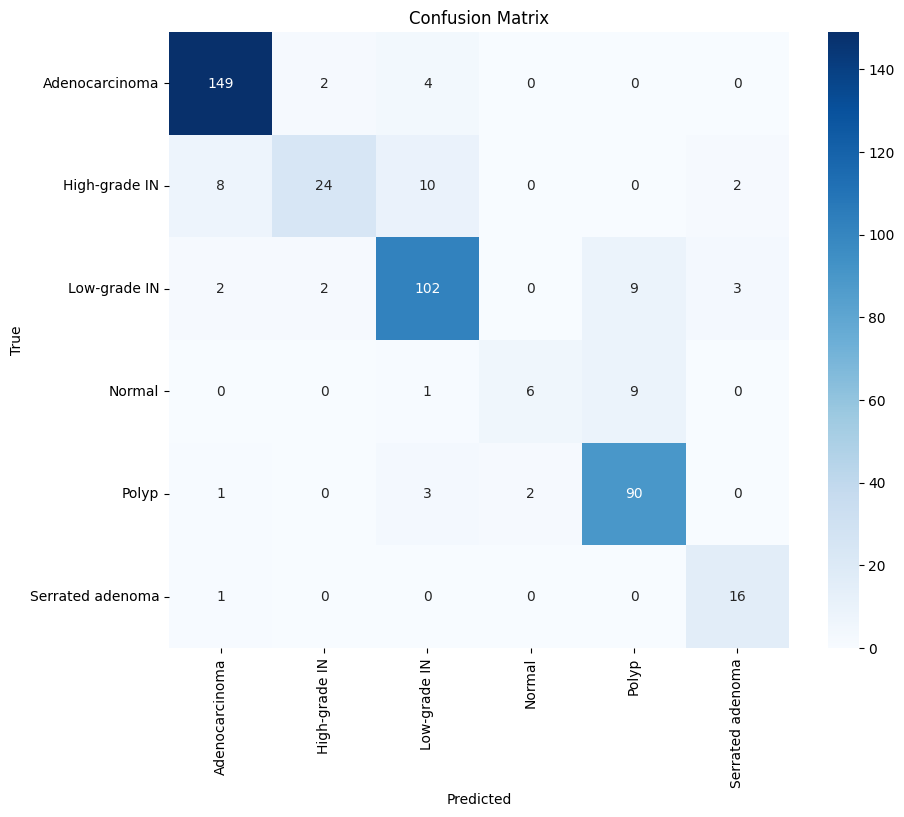

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, dataloader, class_names):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)

    # Plotting the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

print("Generating confusion matrix for the validation set...")
plot_confusion_matrix(model, val_dataloader, class_names)